In [1]:
##PV and GPH joint

In [2]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

/tmp/ipykernel_201340/3801934532.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

2024-12-03 22:53:57.615261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:53:57.615331: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:53:57.615370: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:53:57.621316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
tf.compat.v1.disable_eager_execution()
import innvestigate
import investigate

In [5]:
from climoprobs import climo

#### Upload data. 

In [6]:
#inputs
##now, PVU
infile = open("../data/1203_pv.p", 'rb') 
pvu = pickle.load(infile)
infile.close()

infile = open("../data/1203_g.p", 'rb') 
gph = pickle.load(infile)
infile.close()

#outputs
infile = open("../data/1203_classmedian_t.p", 'rb')
temp = pickle.load(infile)
infile.close()

infile = open("../data/1203_classmedian_g.p", 'rb')
gph_red = pickle.load(infile)
infile.close()

In [7]:
pvu.shape

(63, 151, 11, 145)

In [61]:
length = 144
end_pv = 144
end_gph = 151

In [62]:
gph_n = np.zeros((63,length))
input_pvu = np.zeros((63,length,11,145))

for i in range(63):
    for j in range(end_pv):
        gph_n[i,j] = gph_red[i,j+7]
        input_pvu[i,j] = pvu[i,j,:,:]

In [63]:
temp_n = np.zeros((63,length))
input_gph= np.zeros((63,length,21,37))

for i in range(63):
    for j in range(10,end_gph):
        #print(j)
        temp_n[i,j-10] = temp[i,j]
        input_gph[i,j-10] = gph[i,j-3,:,:]

In [64]:
##input shape (samples, lat, lon) and (#samples, window, features)
print(input_gph.shape)
print(input_pvu.shape)

(63, 144, 21, 37)
(63, 144, 11, 145)


In [65]:
##output shape (samples), these will be different from the input
gph_n.shape

(63, 144)

In [66]:
train_edge = int((63*length) - ((63*length)/63)*4)

test_frac = int(((63*length)/63)*6)

In [67]:
##Set X_all and Y_all datasets
X_all1 = np.copy(input_pvu.reshape(63*length,11*145)) ##pvu
Y_all1 = np.copy(gph_n.reshape(63*length))

X_all2 = np.copy(input_gph.reshape(63*length,21*37)) ##gph
Y_all2 = np.copy(temp_n.reshape(63*length))

##training data partition out
X_tri1 = X_all1[:train_edge,:] ##pvu
Y_tri1 = Y_all1[:train_edge]

X_tri2 = X_all2[:train_edge,:] ##gph
Y_tri2 = Y_all2[:train_edge]

#testing data partition out
X_tes1 = X_all1[train_edge:,:]
Y_tes1 = Y_all1[train_edge:]

X_tes2 = X_all2[train_edge:,:]
Y_tes2 = Y_all2[train_edge:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all1 = keras.utils.to_categorical(Y_all1)
Y_tri1 = keras.utils.to_categorical(Y_tri1)
Y_tes1= keras.utils.to_categorical(Y_tes1)

Y_all2 = keras.utils.to_categorical(Y_all2)
Y_tri2 = keras.utils.to_categorical(Y_tri2)
Y_tes2= keras.utils.to_categorical(Y_tes2)

In [68]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all2)) or np.any(np.isinf(X_all2)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all2)) or np.any(np.isinf(Y_all2)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [69]:
##set 6 years of data for validation
frac_ind = test_frac 
frac_ind

864

In [70]:
##checking to make sure shape was properly one hot encoded
Y_all2.shape

(9072, 2)

In [71]:
Y_all1.shape

(9072, 2)

In [72]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [73]:
##number of input nodes
input_shape1=  X_all1.shape[-1] # pvu
input_shape2= X_all2.shape[-1] ## gph

##fraction of training data
X_validation1 = X_tri1[0:frac_ind]
Y_validation1 = Y_tri1[0:frac_ind]
X_validation2 = X_tri2[0:frac_ind]
Y_validation2 = Y_tri2[0:frac_ind]
        
X_train1 = X_tri1[frac_ind:len(X_tri1)]
Y_train1 = Y_tri1[frac_ind:len(Y_tri1)]
X_train2 = X_tri2[frac_ind:len(X_tri2)]
Y_train2 = Y_tri2[frac_ind:len(Y_tri2)]

X_test1 = X_tes1
Y_test1 = Y_tes1
X_test2 = X_tes2
Y_test2 = Y_tes2

In [74]:
Y_train2.shape

(7632, 2)

In [75]:
input_shape1

1595

In [76]:
input_shape2

777

In [77]:
##do the class_dict weights
class_weight1 = class_weight_creator(Y_train1)
class_weight1

{0: 1.0, 1: 1.028169}

In [78]:
class_weight2 = class_weight_creator(Y_train2)
class_weight2

{0: 1.0, 1: 1.1602038}

In [79]:
##dictionaries for training and validation
X_train = {'model1': X_train1, 'model2': X_train2}
X_all = {'model1': X_all1, 'model2': X_all2}
X_test = {'model1': X_test1, 'model2': X_test2}
X_val = {'model1': X_validation1, 'model2': X_validation2}

Y_train = {'output1': Y_train1, 'output2': Y_train2}
Y_all = {'output1': Y_all1, 'output2': Y_all2}
Y_test = {'output1': Y_test1, 'output2': Y_test2}
Y_val = {'output1': Y_validation1, 'output2': Y_validation2}

class_weight = {'output1': class_weight1, 'output2': class_weight2}

### Model Arcitecture.

In [80]:
def combined(input_shape1, input_shape2, num_cats, n1, n2, n3, n4, reg1, reg2, reg3, reg4, learn):
    ##first layers for PVU ANN
    input_tensor1 = Input(shape=(int(input_shape1),), name='model1')
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg1))(input_tensor1)
   
    layer1 = layers.Dense(n2, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg2))(layer1)
    output_tensor1 = layers.Dense(num_cats,activation='softmax', name='output1')(layer1)
    

    ## second layers for GPH ANN
    input_tensor2 = Input(shape=(int(input_shape2),), name='model2')
    
    repeated = layers.RepeatVector(input_shape2)(output_tensor1)
    #flatten output_tensor1_
    flattened = layers.Flatten()(repeated)
    combined = layers.Concatenate(axis=-1)([input_tensor2, flattened])
    
    layer2 = layers.Dense(n3, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg3))(combined)
    layer2 = layers.Dense(n4, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg4))(layer2)

    output_tensor2 = layers.Dense(num_cats,activation='softmax', name='output2')(layer2)
    
    model = Model([input_tensor1, input_tensor2], output_tensor2)
    
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = {"output2":"categorical_crossentropy"}
              , #Our loss function is based on categorical error
             metrics={'output2': keras.metrics.categorical_accuracy}, #We will print out the categorical accuracy as the network is trained
              )
    return model

In [81]:
######
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [82]:
##create model.
model = combined(input_shape1, input_shape2, 2, 124, 4, 120, 12, 0.74, 0.098, 0.021, 0.056, 0.0016)


early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [83]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
          batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight)#callbacks=[early_stopping])

Train on 7632 samples, validate on 864 samples
Epoch 1/50
2048/7632 [=======>......................] - ETA: 0s - loss: 150.7486 - categorical_accuracy: 0.5059

2024-12-03 23:27:08.971424: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_7/bias/m/Assign' id:1399 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_7/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_7/bias/m, training_2/Adam/dense_7/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7632/7632 [==============================] - 0s 48us/sample - loss: 77.0784 - categorical_accuracy: 0.6181 - val_loss: 15.8638 - val_categorical_accuracy: 0.6852
Epoch 2/50
4096/7632 [===============>..............] - ETA: 0s - loss: 9.2548 - categorical_accuracy: 0.6719 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7632/7632 [==============================] - 0s 31us/sample - loss: 6.5641 - categorical_accuracy: 0.6694 - val_loss: 2.4451 - val_categorical_accuracy: 0.6725
Epoch 3/50
7632/7632 [==============================] - 0s 33us/sample - loss: 1.8703 - categorical_accuracy: 0.6743 - val_loss: 1.4109 - val_categorical_accuracy: 0.6840
Epoch 4/50
7632/7632 [==============================] - 0s 38us/sample - loss: 1.2638 - categorical_accuracy: 0.6744 - val_loss: 1.0504 - val_categorical_accuracy: 0.6898
Epoch 5/50
7632/7632 [==============================] - 0s 34us/sample - loss: 1.0037 - categorical_accuracy: 0.6756 - val_loss: 0.8664 - val_categorical_accuracy: 0.6956
Epoch 6/50
7632/7632 [==============================] - 0s 34us/sample - loss: 0.8734 - categorical_accuracy: 0.6678 - val_loss: 0.7824 - val_categorical_accuracy: 0.6852
Epoch 7/50
7632/7632 [==============================] - 0s 33us/sample - loss: 0.7922 - categorical_accuracy: 0.6733 - val_loss: 0.7122 - val_categorical_ac

In [84]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_val)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-03 23:27:22.656779: W tensorflow/c/c_api.cc:305] Operation '{name:'output2_1/Softmax' id:1014 op device:{requested: '', assigned: ''} def:{{{node output2_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output2_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

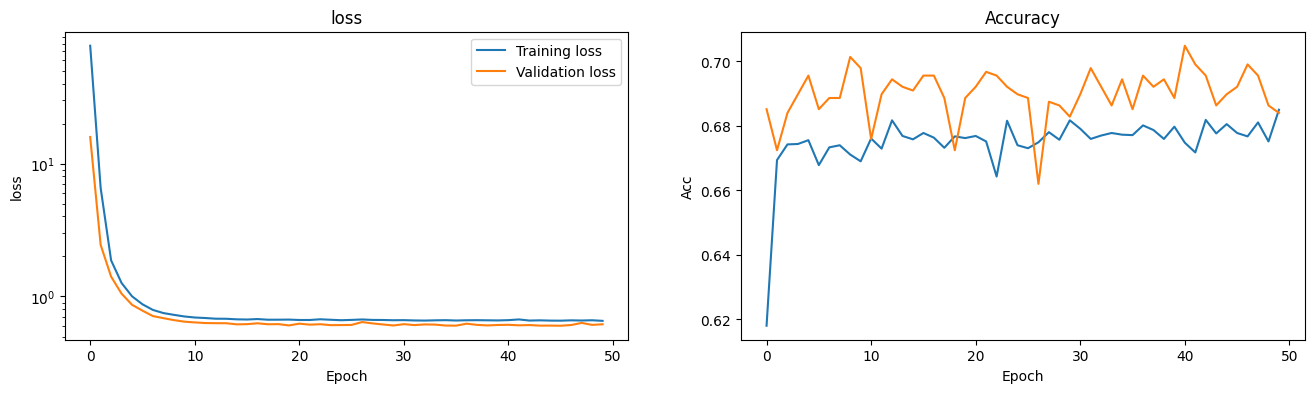

In [85]:
# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend

In [86]:
##calculate climatologies

climo_full = climo(Y_all2,63,length)
climo_train = climo(Y_train2,53,length)
climo_val = climo(Y_validation2,6,length)
climo_test = climo(Y_test2,4,length)

In [87]:
#from google gemini, thanks google
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    """
    Calculates accuracy given true labels and predicted probabilities.
    Args:
        y_true: Array of true labels (e.g., [0, 1, 1, 0]).
        y_prob: Array of predicted probabilities (e.g., [0.3, 0.7, 0.9, 0.2]).
        threshold: Threshold to convert probabilities to binary predictions.
    Returns:
        Accuracy score (float).
    """

    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [88]:
q90 = np.percentile(pred_train,90,axis=0)
q90

array([0.80272985, 0.79450199])

In [89]:
great90 = [i for i, row in enumerate(pred_train)
           if any(pred_train > q90[i] for i, pred_train in enumerate(row))]

# Create the arrays of probabilities and actual values that exceed the 90th percentile
test90 = pred_train[great90]
test90_norm = Y_train2[great90]

print(len(test90))
print(len(test90_norm))

1528
1528


In [90]:
acc = calculate_accuracy(test90_norm, test90, threshold=0.5)
acc

0.8579842931937173

In [91]:
for j in range(len(climo_full[0,:])):
    bs = brier_score_loss(Y_all2[:,j], pred[:,j])
    bs_ref = brier_score_loss(Y_all2[:,j], climo_full[:,j])
    bss = 1 - (bs / bs_ref)

In [92]:
import sklearn
pred_class = []
for k in range(len(Y_all2[:,0])):##PREDICTIVE
    #print(pred_val[k,0])
    #print(pred_val[k,1])
    #print(pred_val[k,2])
    if pred[k,0] > pred[k,1]:
        #print("a")
        pred_class.append([1.,0.])
    elif pred[k,1] > pred[k,0]:
        #print("b")
        pred_class.append([0.,1.])
prd = np.asarray(pred_class)
for j in range(len(climo_full[0,:])):
    recal = sklearn.metrics.recall_score(Y_all2[:,j], prd[:,j])

In [93]:
pred_class = []
for k in range(len(Y_all2[:,0])):##PREDICTIVE
    #print(pred_val[k,0])
    #print(pred_val[k,1])
    #print(pred_val[k,2])
    if pred[k,0] > pred[k,1]:
        #print("a")
        pred_class.append([1.,0.])
    elif pred[k,1] > pred[k,0]:
        #print("b")
        pred_class.append([0.,1.])
prd = np.asarray(pred_class)
for j in range(len(climo_full[0,:])):
    prec = sklearn.metrics.precision_score(Y_all2[:,j], prd[:,j])

In [94]:
print("Brier Skill Score: ",bss)
print("Recall Accuracy Score: ",recal)
print("Precision Accuracy Score: ",prec)

Brier Skill Score:  0.04494227656266836
Recall Accuracy Score:  0.7295238095238096
Precision Accuracy Score:  0.6380674718867139


In [95]:
#################################################### COMPS

In [96]:
q90 = np.percentile(pred_test,90,axis=0) ##identify the threshold for the 90th percentile of confidence
##AS before with checking the threshold
great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]

##classify the accuracy of predicitons
correct_pos = [] #correct positive anomaly
correct_neg = [] #correct negative anomaly

false_pos = [] #false positive
false_neg = [] #false negative

for j in range(len(great90)):
    #print(j)
    #print(great90[j])
    index = great90[j]
    if pred_test[index,0] < pred_test[index,1] and Y_test1[index,0] == 0:
        correct_pos.append(index)
        #print('###########')
    elif pred_test[index,0] > pred_test[index,1] and Y_test1[index,0] == 1:
        correct_neg.append(index)
        #print('###########')
    elif pred_test[index,0] < pred_test[index,1] and Y_test1[index,0] == 1:
        false_neg.append(index)
        #print('###########')
    elif pred_test[index,0] > pred_test[index,1] and Y_test1[index,0] == 0:
        false_pos.append(index)
        #print('###########')

In [97]:
PV_comp_pos= np.nanmean(X_test1[correct_pos],axis=0) 
GPH_comp_pos = np.nanmean(X_test2[correct_pos],axis=0)

PV_comp_neg = np.nanmean(X_test1[correct_neg],axis=0)
GPH_comp_neg = np.nanmean(X_test2[correct_neg],axis=0) 

PV_comp_Fpos = np.nanmean(X_test1[false_pos],axis=0)
GPH_comp_Fpos = np.nanmean(X_test2[false_pos],axis=0) 

PV_comp_Fneg = np.nanmean(X_test1[false_neg],axis=0) 
GPH_comp_Fneg = np.nanmean(X_test2[false_neg],axis=0) 

In [98]:
##for composites
pickle.dump(PV_comp_pos, open("PVU100_comp_pos_lag.p",'wb'))
pickle.dump(PV_comp_Fpos, open("PVU100_compFpos_lag.p",'wb'))
pickle.dump(PV_comp_neg, open("PVU100_comp_neg_lag.p",'wb'))
pickle.dump(PV_comp_Fneg, open("PVU100_compFneg_lag.p",'wb'))

##for composites
pickle.dump(GPH_comp_pos, open("GPH500_comp_pos_lag.p",'wb'))
pickle.dump(GPH_comp_Fpos, open("GPH500_compFpos_lag.p",'wb'))
pickle.dump(GPH_comp_neg, open("GPH500_comp_neg_lag.p",'wb'))
pickle.dump(GPH_comp_Fneg, open("GPH500_compFneg_lag.p",'wb'))

In [ ]:
#################LRP not working lol##########

def replace_softmax(m):
    for layer in m.layers:
        if isinstance(layer, layers.Dense):
            #if layer.activation == keras.activations.softmax:
                #layer.activation = None  
            if layer.activation != keras.activations.relu:
                layer.activation = keras.activations.relu
    new_model = Model(inputs=m.inputs, outputs=m.outputs)
    return new_model

update = replace_softmax(model)

gradient_analyzer = innvestigate.create_analyzer("deep_taylor",update)

analysis = gradient_analyzer.analyze(X_train)

pvu_lrp = analysis[0]

pvuLRP_heatmaps = pvu_lrp.reshape(pvu_lrp.shape[0], 11, 145)
pvuLRP_heatmaps_scaled = pvuLRP_heatmaps/np.nanmax(pvuLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
pvuLRP_heatmaps_mean = np.nanmean(pvuLRP_heatmaps_scaled, axis=0)

gphLRP_heatmaps = gph_lrp.reshape(gph_lrp.shape[0], 21, 37)
gphLRP_heatmaps_scaled = gphLRP_heatmaps/np.nanmax(gphLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
gphLRP_heatmaps_mean = np.nanmean(gphLRP_heatmaps_scaled, axis=0)

#lat
lats1 = np.arange(90, 62.5, -2.5)
#lon
lons1 = np.arange(0, 362.5, 2.5)

color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
plt.figure(figsize=(7.5,7.5))
def define_map():
    from matplotlib.path import Path

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.coastlines()

    # From example: http://scitools.org.uk/cartopy/docs/latest/examples/always_circular_stereo.html
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    return(fig, ax)
    

fig, ax = define_map()
plt.contourf(lons1,lats1,pvuLRP_heatmaps_mean,level,transform=ccrs.PlateCarree(), cmap=color)
plt.colorbar(orientation = 'horizontal', shrink=1,fraction=0.1,pad=0.05,aspect=35, label="Frequency")

plt.tight_layout()
#title = 'Frequency LRP of 100hPa PVU associated with 10% Most Confident & Correct - Temp Anomaly'
#plt.title(title,fontsize=11)
plt.show()

#lat
lats = np.arange(80, 29.5, -2.5)
#lon
lons = np.arange(-100, -9.5, 2.5)

color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lons, lats, gphLRP_heatmaps_mean, level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=35)
cbar.ax.tick_params(labelsize=10) 
#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('Latitude',fontsize=10);
ax.set_xlabel('Longitude',fontsize=10);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()